In [1]:
#This cell is purely for loading the data and setting the directories for convenience

!wget --no-check-certificate \
https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
-O /tmp/cats_and_dogs_filtered.zip

#This loads in the dataset you'll be using for this project.
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')  #some of this data will be split for validation later
testing_dir = os.path.join(base_dir, 'validation')  #this data will be reserved for testing despite the directory's name

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')
# Directory with our validation cat pictures
testing_cats_dir = os.path.join(testing_dir, 'cats')
# Directory with our validation dog pictures
testing_dogs_dir = os.path.join(testing_dir, 'dogs')


--2019-08-02 21:45:33--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.141.128, 2607:f8b0:400c:c06::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   150MB/s    in 0.4s    

2019-08-02 21:45:33 (150 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [0]:
#this code block is useful for demonstrating a later point...

os.chdir(train_dir)
print(os.listdir())
os.chdir('cats')
print(os.listdir())

['cats', 'dogs']
['cat.437.jpg', 'cat.101.jpg', 'cat.65.jpg', 'cat.351.jpg', 'cat.479.jpg', 'cat.807.jpg', 'cat.592.jpg', 'cat.232.jpg', 'cat.572.jpg', 'cat.425.jpg', 'cat.224.jpg', 'cat.381.jpg', 'cat.205.jpg', 'cat.84.jpg', 'cat.995.jpg', 'cat.504.jpg', 'cat.169.jpg', 'cat.529.jpg', 'cat.132.jpg', 'cat.140.jpg', 'cat.828.jpg', 'cat.848.jpg', 'cat.235.jpg', 'cat.958.jpg', 'cat.631.jpg', 'cat.376.jpg', 'cat.248.jpg', 'cat.696.jpg', 'cat.447.jpg', 'cat.757.jpg', 'cat.299.jpg', 'cat.787.jpg', 'cat.514.jpg', 'cat.934.jpg', 'cat.111.jpg', 'cat.117.jpg', 'cat.978.jpg', 'cat.3.jpg', 'cat.218.jpg', 'cat.877.jpg', 'cat.83.jpg', 'cat.464.jpg', 'cat.729.jpg', 'cat.760.jpg', 'cat.100.jpg', 'cat.864.jpg', 'cat.852.jpg', 'cat.854.jpg', 'cat.203.jpg', 'cat.905.jpg', 'cat.463.jpg', 'cat.569.jpg', 'cat.368.jpg', 'cat.446.jpg', 'cat.949.jpg', 'cat.304.jpg', 'cat.91.jpg', 'cat.924.jpg', 'cat.417.jpg', 'cat.724.jpg', 'cat.189.jpg', 'cat.649.jpg', 'cat.231.jpg', 'cat.515.jpg', 'cat.347.jpg', 'cat.892.jpg'

In [0]:
import numpy as np  #storing the data using this
import cv2  #for reading the images into grayscale vectors
from PIL import Image  #used to manipulate the images into the appropriate sizes
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from keras.preprocessing.image import ImageDataGenerator as IDG  #keras's built in image augmentor, which is perfect due to our limited data set.

size = (160, 160)  #the new size of each image after resizing. Dimensions are still up in the air

#using IDG, make an augmentor with the parameters indicating what augmentations can take place.

aug_generator = IDG(rescale=1./255,  #this is to normalize each pixel's numerical values to between 0 and 1, since RGB values go from 0 to 255.
                    rotation_range=45,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    shear_range=0.2,
                    zoom_range=0.2,
                    horizontal_flip=True,
                    fill_mode='nearest',
                    validation_split=0.2)  #some of our data will be used for validation, so split it off


normal_generator = IDG(rescale=1./255)  #no need to have augmentation parameters since the model isn't being trained to fit data generated by this. 
                                        # Just normalize the data appropriately.

#we'll use our augmented data generator instead of just extracting our training data. IDG has something perfect for this,
#considering we have the directories already.

#needed data generators
training_generator = aug_generator.flow_from_directory(train_dir,
                                                       target_size=size,  #force resizes all input images, super nice.
                                                       batch_size=20,
                                                       class_mode='binary',
                                                       subset='training')  

validation_generator = aug_generator.flow_from_directory(train_dir,
                                                         target_size=size,
                                                         batch_size=10,
                                                         class_mode='binary',
                                                         subset='validation')

testing_generator = normal_generator.flow_from_directory(testing_dir,
                                                         target_size=size,
                                                         batch_size=20,
                                                         class_mode='binary')

#This is why we have the data separated into two subdirectories in the training and validation directories.
#The way the data can tell the cats from the dogs is simply due to the fact that they are in two different
#sub directories as they flow in from their main directories. The generator automatically applies labels to
#them this way. Super useful. And since validation and training have the same subdirectories, the labels will
#be the same as well, which is required.

Using TensorFlow backend.


Found 1600 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [0]:
from tensorflow.keras.models import Sequential as seq
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout

def createModel():
  model = seq()
  model.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=(size[0],size[1],3)))                                                                                       #The 3 indicates RGB, since we don't need to grayscale.
  model.add(MaxPooling2D((2,2)))  #reduces dimensionality for computational ease
  
  model.add(Conv2D(64, kernel_size=3, activation='relu'))
  model.add(MaxPooling2D((2,2)))
  
  model.add(Conv2D(128, kernel_size=3, activation='relu'))
  model.add(MaxPooling2D((2,2)))
  
  model.add(Conv2D(256, kernel_size=3, activation='relu'))
  model.add(MaxPooling2D((2,2)))
  
  model.add(Dropout(0.5))
  
  model.add(Flatten())  #allows the data from the previous layer to be fed into a standard dense layer
  
  #the rest of these is architecture of the normal deep neural network

  model.add(Dense(1024, activation='relu'))
  model.add(Dense(1, activation='sigmoid')) 
  
  print(model.summary())
  return model

myModel = createModel()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 158, 158, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 79, 79, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 77, 77, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 38, 38, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 36, 36, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 256)       2

In [0]:
from tensorflow.keras.models import Sequential as seq
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

def createModel():
  model = seq()
  model.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=(size[0],size[1],3)))
  model.add(MaxPooling2D((2,2)))
  
  model.add(Conv2D(64, kernel_size=3, activation='relu'))
  model.add(MaxPooling2D((2,2)))
  
  model.add(Conv2D(128, kernel_size=3, activation='relu'))
  model.add(MaxPooling2D((2,2)))
  
  model.add(Flatten())  #allows MaxPooling feature map to be interpreted as a vector
  
  model.add(Dense(550, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))

Note that recall and precision, in this case, are not very important. The errors of identifying a cat as a dog and vice versa are of equal consequence; thus, there is no real reason to check for recall and precision, and relying on accuracy is a good enough metric to judge our CNN. Based on this, we can now compile and train our model with accuracy as its sole metric.

In [0]:
from tensorflow.keras.optimizers import RMSprop  #special kind of optimizer that allows 

myModel.compile(loss='binary_crossentropy',
                optimizer=RMSprop(lr=2e-4),  #learning rate of 0.0002 originally
                metrics=['accuracy'])

t_history = myModel.fit_generator(training_generator, 
                                  validation_data=validation_generator,
                                  validation_steps=40,
                                  epochs=100,
                                  steps_per_epoch=80)
                                
  

Epoch 1/100
80/80 [==============================] - 17s 219ms/step - loss: 0.3654 - acc: 0.8450 - val_loss: 0.4732 - val_acc: 0.7975
Epoch 2/100
80/80 [==============================] - 15s 192ms/step - loss: 0.3338 - acc: 0.8556 - val_loss: 0.4745 - val_acc: 0.7900
Epoch 3/100
80/80 [==============================] - 15s 190ms/step - loss: 0.3263 - acc: 0.8619 - val_loss: 0.4538 - val_acc: 0.7950
Epoch 4/100
80/80 [==============================] - 15s 189ms/step - loss: 0.3475 - acc: 0.8475 - val_loss: 0.5173 - val_acc: 0.7725
Epoch 5/100
80/80 [==============================] - 15s 187ms/step - loss: 0.3400 - acc: 0.8581 - val_loss: 0.4304 - val_acc: 0.7950
Epoch 6/100
80/80 [==============================] - 15s 188ms/step - loss: 0.3269 - acc: 0.8550 - val_loss: 0.5341 - val_acc: 0.8000
Epoch 7/100
80/80 [==============================] - 15s 191ms/step - loss: 0.3336 - acc: 0.8556 - val_loss: 0.5735 - val_acc: 0.7975
Epoch 8/100
80/80 [==============================] - 15s 191ms

In [0]:
 testing_loss, testing_acc = myModel.evaluate_generator(testing_generator)

print("Testing loss: {}".format(testing_loss))
print("Testing accuracy: {}".format(testing_acc))

Testing loss: 0.5819447332620621
Testing accuracy: 0.7009999752044678


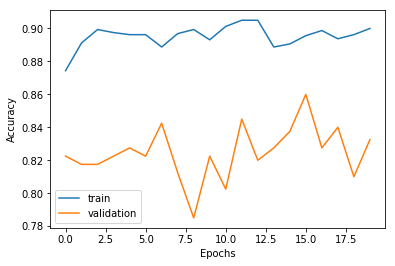

In [0]:
plt.plot(t_history.history['acc'])
plt.plot(t_history.history['val_acc'])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(['train', 'validation'])
plt.show()

In [0]:
#make a directory for saving models to

os.chdir("/content")
os.mkdir("saved_models")

In [0]:
#save the current model to a file

os.chdir("/content")
os.chdir("saved_models")
model_num = 3  #change this manually after the run. this was the best model we had
myModel.save("model_{}.h5".format(model_num))  #remember to download it locally

In [0]:
from tensorflow.keras.models import load_model  #Run this block
os.chdir("/content")
os.chdir("saved_models")
iModel = load_model('model_3.h5')  #load the good model back in

W0726 16:36:37.280960 140339859502976 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0726 16:36:37.283983 140339859502976 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [0]:
#this is the training done on the already adjusted and reloaded model, for a bit more optimization

iModel.compile(loss='binary_crossentropy',
                optimizer=RMSprop(lr=2e-6),  #decrease the learning rate
                metrics=['accuracy'])

i_history = iModel.fit_generator(training_generator,  #continue the training with the smaller learning rate
                                  validation_data=validation_generator,
                                  validation_steps=40,
                                  epochs=10,
                                  steps_per_epoch=80)

Epoch 1/10
80/80 [==============================] - 18s 231ms/step - loss: 0.5878 - acc: 0.7025 - val_loss: 0.6008 - val_acc: 0.6600
Epoch 2/10
80/80 [==============================] - 16s 200ms/step - loss: 0.5879 - acc: 0.6988 - val_loss: 0.5953 - val_acc: 0.6850
Epoch 3/10
80/80 [==============================] - 16s 201ms/step - loss: 0.5792 - acc: 0.7106 - val_loss: 0.5998 - val_acc: 0.6850
Epoch 4/10
14/80 [====>.........................] - ETA: 3s - loss: 0.5924 - acc: 0.7071

KeyboardInterrupt: ignored

In [0]:
itesting_loss, itesting_acc = iModel.evaluate_generator(testing_generator)

print("Testing loss: {}".format(itesting_loss))
print("Testing accuracy: {}".format(itesting_acc))

itraining_loss, itraining_acc = iModel.evaluate_generator(training_generator)

print("Training loss: {}".format(itraining_loss))
print("Training accuracy: {}".format(itraining_acc))

plt.plot(i_history.history['acc'])
plt.plot(i_history.history['val_acc'])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(['train', 'validation'])
plt.show()

Testing loss: 0.5712136608362198
Testing accuracy: 0.6949999928474426


KeyboardInterrupt: ignored

In [0]:
os.chdir("/content")
os.chdir("saved_models")
model_num = 7  #change this manually after the run.
iModel.save("model_{}.h5".format(model_num))  #remember to download it locally

os.listdir()

['model_3.h5', 'model_7.h5']

In [0]:
#test everything on grayscale one last time

#create generators for grayscale instead
tr_g_generator = aug_generator.flow_from_directory(train_dir,
                                                   target_size=size,  #force resizes all input images, super nice.
                                                   batch_size=20,
                                                   class_mode='binary',
                                                   color_mode='grayscale',
                                                   subset='training')  

v_g_generator = aug_generator.flow_from_directory(train_dir,
                                                  target_size=size,
                                                  batch_size=10,
                                                  class_mode='binary',
                                                  color_mode='grayscale',
                                                  subset='validation')

te_g_generator = normal_generator.flow_from_directory(testing_dir,
                                                      target_size=size,
                                                      batch_size=20,
                                                      color_mode='grayscale',
                                                      class_mode='binary')

def createGModel():  #model for testing on grayscale
  model = seq()
  model.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=(size[0],size[1],1)))  #the 1 indicates grayscale this time.     
  model.add(MaxPooling2D((2,2)))  #reduces dimensionality for computational ease, since we kept stride at 1. 2 by 2 is generally good for pooling
  
  model.add(Conv2D(64, kernel_size=3, activation='relu'))
  model.add(MaxPooling2D((2,2)))
  
  model.add(Conv2D(128, kernel_size=3, activation='relu'))
  model.add(MaxPooling2D((2,2)))
  
  model.add(Conv2D(256, kernel_size=3, activation='relu'))
  model.add(MaxPooling2D((2,2)))
  
  model.add(Dropout(0.5))
  
  model.add(Flatten())  #allows the data from the previous layer to be fed into a standard dense layer
  
  #the rest of these is architecture of the normal deep neural network

  model.add(Dense(1024, activation='relu'))
  model.add(Dense(1, activation='sigmoid')) 
  
  print(model.summary())
  return model

gModel = createGModel()

Found 1600 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 158, 158, 32)      320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 79, 79, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 77, 77, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 38, 38, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 36, 36, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 18, 18, 128)       0     

In [0]:
gModel.compile(loss='binary_crossentropy',
                optimizer=RMSprop(lr=2e-8),  #learning rate of 0.0002 originally
                metrics=['accuracy'])

g_history = gModel.fit_generator(tr_g_generator, 
                                 validation_data=v_g_generator,
                                 validation_steps=40,
                                 epochs=10,
                                 steps_per_epoch=80)

In [0]:
#data from the grayscale model

gtesting_loss, gtesting_acc = gModel.evaluate_generator(te_g_generator)

print("Testing loss: {}".format(gtesting_loss))
print("Testing accuracy: {}".format(gtesting_acc))

gtraining_loss, gtraining_acc = gModel.evaluate_generator(tr_g_generator)

print("Training loss: {}".format(gtraining_loss))
print("Training accuracy: {}".format(gtraining_acc))

plt.plot(g_history.history['acc'])
plt.plot(g_history.history['val_acc'])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(['train', 'validation'])
plt.show()

In [5]:
#the result!
import os
from tensorflow.keras.models import load_model

os.chdir("/content")

best_model = load_model("final_model.h5")  #this is our final model

btesting_loss, btesting_acc = best_model.evaluate_generator(testing_generator)

print("Testing loss: {}".format(btesting_loss))
print("Testing accuracy: {}".format(btesting_acc))

btraining_loss, btraining_acc = best_model.evaluate_generator(training_generator)

print("Training loss: {}".format(btraining_loss))
print("Training accuracy: {}".format(btraining_acc))

Testing loss: 0.3662406726181507
Testing accuracy: 0.8640000224113464
Training loss: 0.2528846205212176
Training accuracy: 0.9012500047683716


In [0]:

from PIL import Image
import requests

def getImage2(url):  
  im = Image.open(requests.get(url, stream=True).raw)
  return im

If you give me an image, I'll try to classify it as a dog or a cat!
Enter the image URL:https://www.prestigeanimalhospital.com/sites/default/files/08-cat-cancer-4.jpeg
Classified as cat.


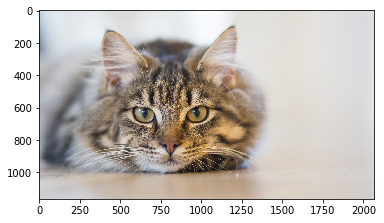

In [10]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

print("If you give me an image, I'll try to classify it as a dog or a cat!")
img_url = str(input("Enter the image URL:"))
retr_img = getImage2(img_url)
plt.imshow(retr_img)

#adjust the image appropriately
retr_img = retr_img.resize(size)
retr_img = np.divide(np.array(retr_img),255)

retr_img = retr_img.reshape(1,size[0],size[1],3)

#print the prediction!
print("Classified as cat.") if best_model.predict(retr_img)[0][0] <= 0.5 else print("Classified as dog.")